In [1]:
# Загрузка необходимых библиотек и модулей

import warnings
warnings.filterwarnings("ignore")

import json
import string

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pyarrow as pa
import pyarrow.parquet as pq 
import pandas as pd
from pandas_profiling import ProfileReport

import re
import numpy as np

import nltk
from nltk import FreqDist
#nltk.download('popular')
from nltk.corpus import stopwords

from pymystem3 import Mystem

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.layers import Dense, Flatten, Embedding, Conv1D, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import L2

In [2]:
# Загружаем тренеровочные данные из файла .parquet

df_train = pq.read_table('train.parquet').to_pandas()
df_train.head()

,product_id,category_id,sale,shop_id,shop_title,rating,text_fields,category_name
0,325286,12171,False,9031,Aksik,5.0,"{""title"": ""Зарядный кабель Borofone BX1 Lightn...",Все категории->Электроника->Смартфоны и телефо...
1,888134,14233,False,18305,Sela,5.0,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-...",Все категории->Одежда->Женская одежда->Белье и...
3,1267173,13429,False,16357,ЮНЛАНДИЯ канцтовары,5.0,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 цветов...",Все категории->Хобби и творчество->Рисование->...
4,1416943,2789,False,34666,вася-nicotine,4.0,"{""title"": ""Колба для кальяна Крафт (разные цве...",Все категории->Хобби и творчество->Товары для ...
5,1058275,12834,False,26389,Lim Market,4.6,"{""title"": ""Пижама женская, однотонная с шортам...",Все категории->Одежда->Женская одежда->Домашня...


In [3]:
# Проверяем датасет на отсутствие дублирующих записей и выводим его размерность

print('Количество дублирующихся записей - ', len(df_train[df_train.duplicated()].values))
df_train.shape

Количество дублирующихся записей -  0


(91120, 8)

In [4]:
# Проверяем отсутствие пропусков и типы данных

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91120 entries, 0 to 99992
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     91120 non-null  int64  
 1   category_id    91120 non-null  int64  
 2   sale           91120 non-null  bool   
 3   shop_id        91120 non-null  int64  
 4   shop_title     91120 non-null  object 
 5   rating         91120 non-null  float64
 6   text_fields    91120 non-null  object 
 7   category_name  91120 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 5.6+ MB


In [5]:
# Проверяем количество категорий целевой переменной

df_train.category_id.value_counts()

11937    6590
14922    3709
13651    1463
13143    1460
12980    1222
         ... 
12808       2
12901       1
11549       1
11875       1
12836       1
Name: category_id, Length: 874, dtype: int64

Целевая переменная имеет 874 класса, при этом классы сильно несбалансированы, миноритарный класс представлен 1 товаром, мажоритарный - 6590.

In [6]:
# Выполним EDA с помощью библиотеки pandas_profiling для нетекстовых столбцов

columns = ['product_id', 'category_id', 'sale', 'shop_id', 'shop_title', 'rating']

profile = ProfileReport(df_train[columns], title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# Просмотрим структуру столбца text_fields с текстовой информацией

df_train.text_fields[0]

'{"title": "Зарядный кабель Borofone BX1 Lightning для айфон, 1м", "description": "<p><span style=\\"background-color: transparent; color: rgb(0, 26, 52);\\">Зарядный кабель Borofone BX1 подходит для зарядки всех гаджетов и аксессуаров с разъемом </span>Lightning.</p><p><span style=\\"color: rgb(0, 26, 52); background-color: transparent;\\">Поддерживает быструю зарядку.</span></p><p><span style=\\"color: rgb(0, 26, 52); background-color: transparent;\\">Подходит для передачи данных.</span></p>", "attributes": ["Длина: 1м", "Разъем: Lightning", "Подерживает быструю зарядку", "Максимальный ток: 2.0А", "Для зарядки и синхронизации данных", "Вес: 22 г."], "custom_characteristics": {}, "defined_characteristics": {"Цвет": ["Черный", "Белый"]}, "filters": {"Цвет": ["Белый", "Черный"]}}'

In [8]:
# Структура похожа на json формат, разделим столбец text_fields на несколько столбцов с соответствующими ключам вложенных 
# словарей названиями столбцов.

text_fields = [json.loads(elem) for elem in df_train.text_fields.tolist()]
idx = df_train.index.tolist()
df = pd.DataFrame(text_fields, index=idx)
df.iloc[10:15, :]

,title,description,attributes,custom_characteristics,defined_characteristics,filters
11,"Аппликации для детей с наклейками, 2 листа, 20...","<p>Аппликации для детей с наклейками, два лист...","[На одном листе небольшая раскраска., Материал...",{},"{'Цвет': ['Алый', 'Розовый', 'Красный', 'Бежев...","{'Цвет': ['Желтый', 'Голубой', 'Белый', 'Бежев..."
12,"Флешка 3 в 1-накопитель Micro USB,Type-C, 4gb,...",<p><strong>О реальной емкости</strong></p><p>4...,"[память для ноутбука пк, флешка для телевизора...","{'Размер': ['64гб', '4гб', '8гб', '16гб', '32г...","{'Цвет': ['Розовый', 'Красный', 'Фиолетовый', ...","{'Цвет': ['Черный', 'Розовый', 'Розовый', 'Жел..."
13,Футболка мужская,100% хлопок,[],{},"{'Размер одежды': ['M', 'S', 'L', 'XXL', 'XL']}",{'Тип футболки': ['Футболка с короткими рукава...
14,"Сувенирные деньги, банк приколов",<p>Юмор – настоящее богатство!</p><p>Купюры в ...,[Около 90 листов в пачке],{},"{'Цвет': ['Голубой', 'Фиолетовый', 'Оранжевый'...","{'Цвет': ['Фиолетовый', 'Розовый', 'Зеленый', ..."
15,Тапочки для девочек комнатные,"<p>Легкая подошва, выполненная из экологическо...",[],{},"{'Детский размер обуви': ['34', '30']}","{'Бренд': ['Smile of Milady', 'Smile of Milady..."


In [9]:
# В столбцах custom_characteristics, defined_characteristics, filters представлена похожая или идентичная информация, 
# объединяем их вместе для последующей совместной обработки. Это же касается столбцов description и attributes.

df.description = df.apply(lambda x: str(x.description) + ' ' + str(x.attributes), axis=1)
df['characteristics'] = df.apply(lambda x: str(x.custom_characteristics) + str(x.defined_characteristics) + str(x.filters), axis=1)
df.drop(columns=['custom_characteristics', 'defined_characteristics', 'filters', 'attributes'], inplace=True)
df.head()

,title,description,characteristics
0,Зарядный кабель Borofone BX1 Lightning для айф...,"<p><span style=""background-color: transparent;...","{}{'Цвет': ['Черный', 'Белый']}{'Цвет': ['Белы..."
1,Трусы Sela,Трусы-слипы из эластичного бесшовного трикотаж...,"{}{'Размер одежды': ['S']}{'Бренд': ['Sela'], ..."
3,"Гуашь ""ЮНЫЙ ВОЛШЕБНИК"", 12 цветов по 35 мл, БО...",<p>Гуашь высшего качества ЮНЛАНДИЯ поможет соз...,{}{}{'Бренд': ['Юнландия']}
4,Колба для кальяна Крафт (разные цвета),"<p><span style=""color: rgb(149, 151, 153);"">Ун...","{}{'Цвет': ['Хром', 'Розовый', 'Желтый', 'Проз..."
5,"Пижама женская, однотонная с шортами",<p>Лёгкая ткань! Комфортная посадка! Идеальная...,"{}{'Размер одежды': ['XXXL', 'L', 'XXL', 'XL']..."


In [10]:
# Вносим столбцы title, description и characteristic в датафрейм, удаляя при этом text_fields
# как неинформативные

df_train = pd.concat([df_train, df], axis=1)
df_train.drop(columns=['text_fields'], inplace=True)
df_train.head()

,product_id,category_id,sale,shop_id,shop_title,rating,category_name,title,description,characteristics
0,325286,12171,False,9031,Aksik,5.0,Все категории->Электроника->Смартфоны и телефо...,Зарядный кабель Borofone BX1 Lightning для айф...,"<p><span style=""background-color: transparent;...","{}{'Цвет': ['Черный', 'Белый']}{'Цвет': ['Белы..."
1,888134,14233,False,18305,Sela,5.0,Все категории->Одежда->Женская одежда->Белье и...,Трусы Sela,Трусы-слипы из эластичного бесшовного трикотаж...,"{}{'Размер одежды': ['S']}{'Бренд': ['Sela'], ..."
3,1267173,13429,False,16357,ЮНЛАНДИЯ канцтовары,5.0,Все категории->Хобби и творчество->Рисование->...,"Гуашь ""ЮНЫЙ ВОЛШЕБНИК"", 12 цветов по 35 мл, БО...",<p>Гуашь высшего качества ЮНЛАНДИЯ поможет соз...,{}{}{'Бренд': ['Юнландия']}
4,1416943,2789,False,34666,вася-nicotine,4.0,Все категории->Хобби и творчество->Товары для ...,Колба для кальяна Крафт (разные цвета),"<p><span style=""color: rgb(149, 151, 153);"">Ун...","{}{'Цвет': ['Хром', 'Розовый', 'Желтый', 'Проз..."
5,1058275,12834,False,26389,Lim Market,4.6,Все категории->Одежда->Женская одежда->Домашня...,"Пижама женская, однотонная с шортами",<p>Лёгкая ткань! Комфортная посадка! Идеальная...,"{}{'Размер одежды': ['XXXL', 'L', 'XXL', 'XL']..."


In [12]:
# В текстовых данных присутствует пунктуация, html теги, кириллические и латинские символы, цифры. В столбца title и 
# description удаляем все не кириллические символы и выполняем лемматизацию с помощью библиотеки pymystem3
# Столбец characteristics содержит информацию о размерах, названии бренда и т.д., соответственно для него удаляем символы, 
# кроме букв, цифр и пробелов и также выполняем лемматизацию. Словарь стоп-слов nltk дополним часто встречающимися словами,
# которые не несут самостоятельной смысловой нагрузки и не имеют пользы для модели

mystem = Mystem()

def clean_text(data, flag):
    cleaned_text = []
    add_stopwords = ['цвет', 'материал', 'ваш', 'подходить', 'товар', 'который', 'это', 'тип', 'наш', 'магазин', 'также', 
                     'состав', 'свой', 'мы', 'данный', 'такой', 'размер', 'благодаря', 'использовать', 'использование', 
                     'мочь', 'изделие', 'вид']
    stopword = stopwords.words('russian') + add_stopwords
    for text in data:
        text = str(text).lower()
        if flag == 'ru_simb':
            text = re.sub(r'[^\sа-яё]', ' ', text).strip().split()
            text = ' '.join([mystem.lemmatize(word)[0] for word in text if not mystem.lemmatize(word)[0] in stopword and len(word)>2])
        else:
            text = re.sub(r'[^\s\w]', ' ', text).strip().split()
            text = ' '.join([mystem.lemmatize(word)[0] for word in text if not mystem.lemmatize(word)[0] in stopword])
        cleaned_text.append(text)        
    return cleaned_text

df_train['title'] = clean_text(df_train.title.tolist(), 'ru_simb')
df_train['description'] = clean_text(df_train.description.tolist(), 'ru_simb')
df_train['characteristics'] = clean_text(df_train.characteristics.tolist(), 'without_punctuation')

In [14]:
# Фильтруем повторения токенов в characteristics и добавляем id магазина. Неинформативные столбцы, которые больше не будут 
# использоваться удаляем

df_train.characteristics = df_train.characteristics.apply(lambda x: ' '.join([i for n, i in enumerate(x.split()) 
                                                                              if i not in x.split()[:n]]))
df_train.characteristics = df_train.apply(lambda x: str(x.shop_id) + ' ' + x.characteristics, axis=1)
df_train.drop(columns=['shop_id', 'category_name', 'product_id', 'shop_title', 'rating', 'sale', 'shop_title'], inplace=True)
df_train.head()

,category_id,title,description,characteristics
0,12171,зарядный кабель айфон,зарядный кабель зарядка гаджет аксессуар разъе...,9031 черный белый
1,14233,трусы,трусы слип эластичный бесшовный трикотаж однот...,18305 размер одежда s бренд sela
3,13429,гуашь юный волшебник цветок большой баночка вы...,гуашь высокий качество юнландия помогать созда...,16357 бренд юнландия
4,2789,колба кальян крафт разный,универсальный колба кальян современный кальян ...,34666 хром розовый желтый прозрачный синий чер...
5,12834,пижама женский однотонный шорты,легкий ткань комфортный посадка идеальный длин...,26389 размер одежда xxxl l xxl xl белый


In [15]:
# Объединяем все документы в единый корпус и рассчитываем количество уникальных токенов

all_words = ' '.join(df_train.title.tolist()) + ' '.join(df_train.description.tolist()) + ' '.join(df_train.characteristics.tolist())
all_words = all_words.split()
print('Всего уникальных токенов - ', len(set(all_words)))
all_words[:5]

Всего уникальных токенов -  60537


['зарядный', 'кабель', 'айфон', 'трусы', 'гуашь']

In [16]:
# Составим словарь частоты токенов в корпусе, где ключами является токен, а значением частота повторений. Затем для удобства
# преобразуем его в датафрейм

freq_dist = FreqDist(all_words)
words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
words_df = words_df.sort_values('count', ascending=False)
words_df.head()

,word,count
338,размер,74845
33,стекло,41554
21,чехол,38801
45,черный,27650
648,модель,25759


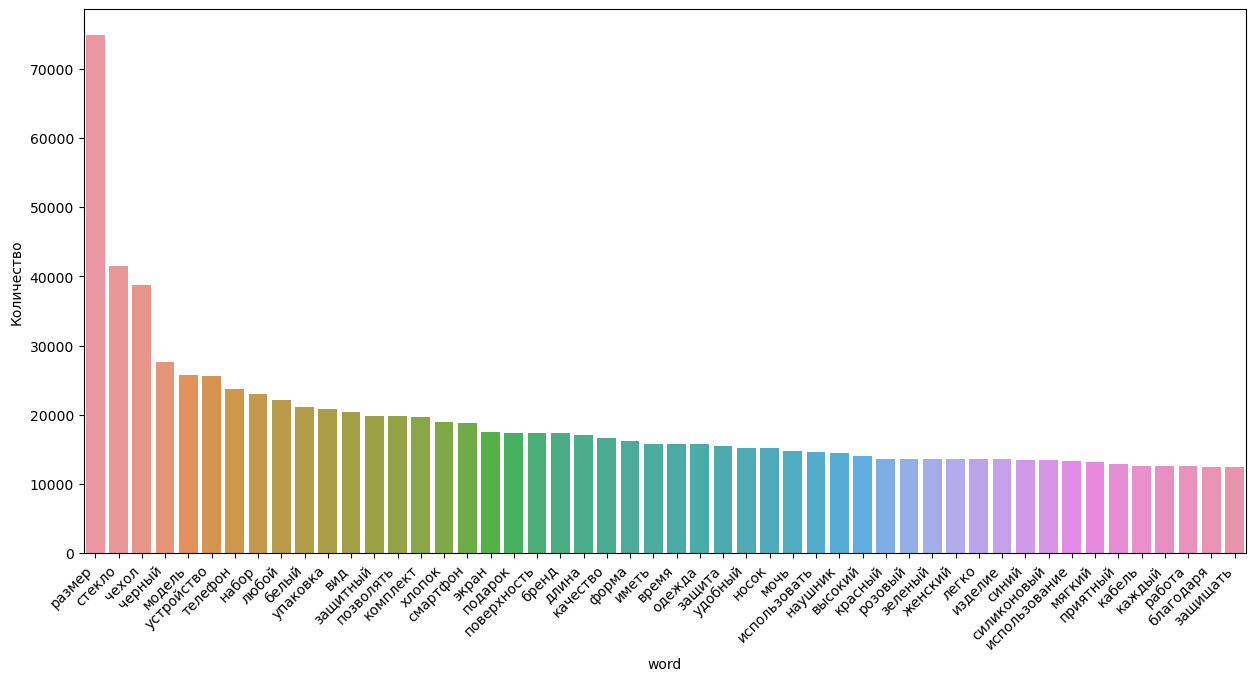

In [17]:
# Выведем на графике наиболее частые 50 слов

def words_frequency(df, top_n = 50):  
    d = df.nlargest(columns='count', n=top_n) 
    fig, ax = plt.subplots(figsize=(15,8))
    ax = sns.barplot(data=d, x='word', y='count')
    ax.set(ylabel='Количество')
    fig.autofmt_xdate(rotation=45);
    plt.show();
    
words_frequency(words_df)

In [19]:
# Рассчитываем количество слов, которые будут токенезированы, при этом не учитываем слова, встречающиеся единожды. Затем 
# обучаем встроенный Tokenizer из tensorflow.keras.preprocessing.text. Предварительно фиксируем seed=1

tf.random.set_seed(42)

num_words=len(words_df[words_df['count'] >= 2])

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts([all_words])
total_words = len(tokenizer.word_index)+1
print('Всего токенов - ',total_words)

Всего токенов -  60538


In [20]:
# Преобразуем токены в числовую последовательность с помощью Tokenizer tensorflow, а также расчитываем длину каждой 
# последовательности

df_train['title_tokenized'] = tokenizer.texts_to_sequences(df_train.title)
df_train['title_tokens_amount'] = df_train.title_tokenized.apply(lambda x: len(x))
df_train['description_tokenized'] = tokenizer.texts_to_sequences(df_train.description)
df_train['description_tokens_amount'] = df_train.description_tokenized.apply(lambda x: len(x))
df_train['characteristics_tokenized'] = tokenizer.texts_to_sequences(df_train.characteristics)
df_train['characteristics_tokens_amount'] = df_train.characteristics_tokenized.apply(lambda x: len(x))
df_train.drop(columns=['title', 'description', 'characteristics'])
df_train.head(3)

,category_id,title,description,characteristics,title_tokenized,title_tokens_amount,description_tokenized,description_tokens_amount,characteristics_tokenized,characteristics_tokens_amount
0,12171,зарядный кабель айфон,зарядный кабель зарядка гаджет аксессуар разъе...,9031 черный белый,"[217, 46, 962]",3,"[217, 46, 59, 403, 109, 75, 442, 273, 59, 443,...",20,"[12785, 4, 10]",3
1,14233,трусы,трусы слип эластичный бесшовный трикотаж однот...,18305 размер одежда s бренд sela,[272],1,"[272, 1291, 189, 1602, 807, 363, 69, 276, 439,...",18,"[2020, 1, 27, 194, 21, 2021]",6
3,13429,гуашь юный волшебник цветок большой баночка вы...,гуашь высокий качество юнландия помогать созда...,16357 бренд юнландия,"[2720, 2808, 8737, 67, 135, 895, 34, 23]",8,"[2720, 34, 23, 4383, 62, 126, 2808, 513, 401, ...",17,"[7409, 21, 4383]",3


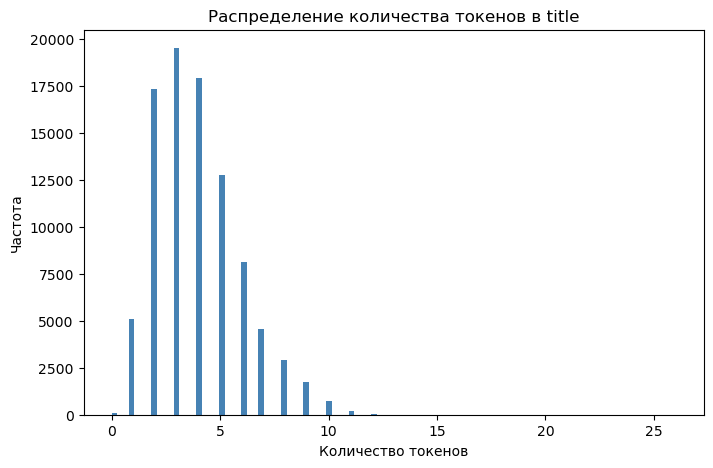

In [21]:
# Выводим графики распределения количества токенов в title_tokenized, description_tokenized и characteristics_tokenized

plt.figure(figsize=(8, 5))
plt.hist(df_train.title_tokens_amount, bins=100, color='steelblue')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.title('Распределение количества токенов в title')
plt.show();

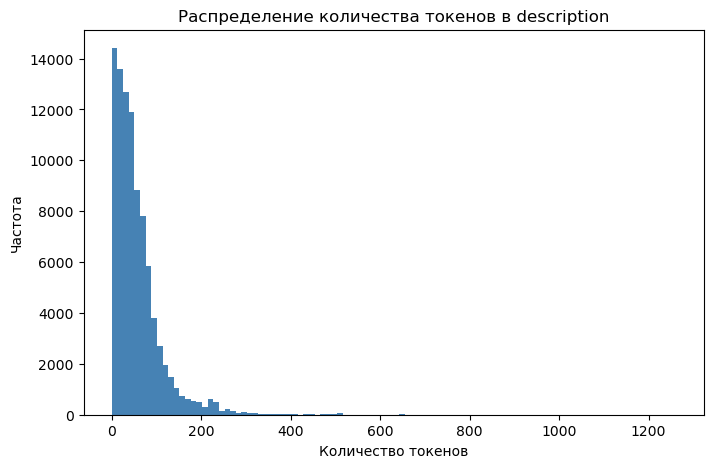

In [22]:
plt.figure(figsize=(8, 5))
plt.hist(df_train.description_tokens_amount, bins=100, color='steelblue')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.title('Распределение количества токенов в description')
plt.show();

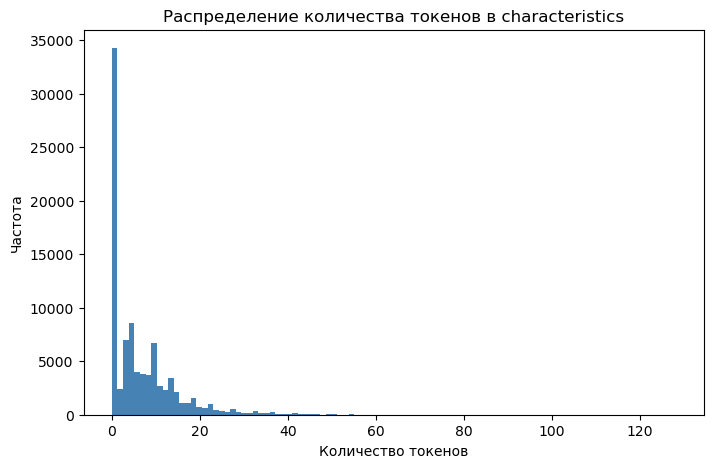

In [23]:
plt.figure(figsize=(8, 5))
plt.hist(df_train.characteristics_tokens_amount, bins=100, color='steelblue')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.title('Распределение количества токенов в characteristics')
plt.show();

In [24]:
# Удаляем категории, представленные только одним товаром в выборке

freq = df_train.category_id.value_counts()
rare = list(freq.index[freq < 2])
for cat in rare:
    df_train = df_train[df_train.category_id != cat]

In [25]:
# Фиксируем количество оставшихся категорий товаров и преобразуем их с помощью LabelEncoder и метода to_categorical tensorflow

num_classes = df_train.category_id.nunique()
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df_train.category_id)
y = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)
print('Итоговое количество классов целевой переменной - ', num_classes)

Итоговое количество классов целевой переменной -  870


In [26]:
# Разделяем датасет на тренировочную и валидационную выборки в соотвношении 80/20 с сохранением соотношения товаров разных 
# категорий

Xtrain, Xval, ytrain, yval = train_test_split(df_train[['title_tokenized', 'description_tokenized', 'characteristics_tokenized']], 
                                              y, train_size=0.8, stratify=y, random_state=42)
print(f'Размер тренировочной выборки - {Xtrain.shape}\nРазмер валидационной выборки - {Xval.shape}')

Размер тренировочной выборки - (72892, 3)
Размер валидационной выборки - (18224, 3)


In [27]:
# Создаем функцию для расчета интерквартильного размаха

def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [28]:
# Для каждого из текстовых признаков выполняем расчет интерквартильного размаха длины последовательностей, с помощью 
# метода pad_sequences tensorflow приводим последовательности в каждом из признаков к одинаковой длине(короткие 
# последовательности будут дополнены нулями с конца последовательности до длины, рассчитанной на основе интерквартильного 
# размаха, длинные будут усечены до нее же). Далее признаки будут объединены в единый признак.
len_list = []
Xtrain_np = np.empty(shape=[len(Xtrain), 0], dtype='int32')
Xval_np = np.empty(shape=[len(Xval), 0], dtype='int32')
for feat in ['title', 'description', 'characteristics']:
    boundaries = calculate_outliers(df_train[feat+'_tokens_amount'])
    print(f'Верхняя граница интерквартильного размаха для длины последовательностей в {feat} - {boundaries[1]}')
    len_sequence = round(boundaries[1])
    len_list.append(len_sequence)
    Xtrain_temp = pad_sequences(Xtrain[feat+'_tokenized'], maxlen=len_sequence, padding='post')
    Xtrain_np = np.append(Xtrain_np, Xtrain_temp, axis=1)
    Xval_temp = pad_sequences(Xval[feat+'_tokenized'], maxlen=len_sequence, padding='post')
    Xval_np = np.append(Xval_np, Xval_temp, axis=1)
Xtrain = Xtrain_np
Xval = Xval_np
len_sequence = Xtrain.shape[1]
print('Размер итогового входного массива - ', Xtrain.shape)

Верхняя граница интерквартильного размаха для длины последовательностей в title - 8.0
Верхняя граница интерквартильного размаха для длины последовательностей в description - 153.5
Верхняя граница интерквартильного размаха для длины последовательностей в characteristics - 23.5
Размер итогового входного массива -  (72892, 186)


In [29]:
# Строим модель нейронной сети с использованием фреймворка Tensorflow. Архитектура нейронной сети представляет собой 
# слой эмбеддинг, 3 сверточных слоя Conv1d, после каждого из них добавлены слои BatchNormalization, MaXPooling и Dropout для
# предотвращения затухания(или взрыва) градиентов, уменьшения размерности и сглаживания сдвигов объектов/токенов, и 
# предотвращения перобучения соответственно. Далее 2 полносвязных слоя с 512 и 870 нейронами и выходной слой.

input = Input(shape=(len_sequence,))
embed = Embedding(num_words, 64, input_length=len_sequence)(input)

conv1 = Conv1D(512, kernel_size=8, padding='same', activation='relu')(embed)
batch1 = BatchNormalization()(conv1)
pool1 = MaxPooling1D()(batch1)
drop1 = Dropout(0.4)(pool1)

conv2 = Conv1D(256, kernel_size=4, padding='same', activation='relu')(drop1)
batch2 = BatchNormalization()(conv2)
pool2 = MaxPooling1D()(batch2)
drop2 = Dropout(0.4)(pool2)

conv3 = Conv1D(128, kernel_size=4, padding='same', activation='relu')(drop2)
batch3 = BatchNormalization()(conv3)
pool3 = MaxPooling1D()(batch3)
drop3 = Dropout(0.4)(pool3)
flat = Flatten()(drop3)

dense1 = Dense(512, activation='relu')(flat)
batch4 = BatchNormalization()(dense1)
drop4 = Dropout(0.4)(batch4)
dense2 = Dense(num_classes, activation='relu')(drop4)

output = Dense(num_classes, activation='softmax', kernel_regularizer=L2(l2=0.01))(dense2)

model = Model(inputs=input, outputs=output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 186)]             0         
                                                                 
 embedding (Embedding)       (None, 186, 64)           2518656   
                                                                 
 conv1d (Conv1D)             (None, 186, 512)          262656    
                                                                 
 batch_normalization (BatchN  (None, 186, 512)         2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 93, 512)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 93, 512)           0     

In [30]:
# В качестве оптимизатора выбираем Adam (он показал результат лучше, чем RMSProp на этапе экспериментов) с lerning_rate=0.001,
# функция потерь - categorical_crossentropy, метрика - f1_score_weighted

adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = [tfa.metrics.F1Score(num_classes=num_classes, average='weighted')])

In [31]:
# Обучаем модель на 100 эпохах с размером партии/batch_size 128

history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), 
                    epochs=30, batch_size=128, verbose=1)

Epoch 1/30
570/570 [==============================] - 52s 85ms/step - loss: 4.5443 - f1_score: 0.2590 - val_loss: 4.0767 - val_f1_score: 0.2558
Epoch 2/30
570/570 [==============================] - 48s 84ms/step - loss: 2.2604 - f1_score: 0.5612 - val_loss: 1.9082 - val_f1_score: 0.6183
Epoch 3/30
570/570 [==============================] - 47s 83ms/step - loss: 1.6751 - f1_score: 0.6726 - val_loss: 1.6097 - val_f1_score: 0.6811
Epoch 4/30
570/570 [==============================] - 47s 83ms/step - loss: 1.3561 - f1_score: 0.7368 - val_loss: 1.4094 - val_f1_score: 0.7289
Epoch 5/30
570/570 [==============================] - 47s 83ms/step - loss: 1.1405 - f1_score: 0.7828 - val_loss: 1.3399 - val_f1_score: 0.7507
Epoch 6/30
570/570 [==============================] - 48s 83ms/step - loss: 0.9981 - f1_score: 0.8133 - val_loss: 1.2698 - val_f1_score: 0.7623
Epoch 7/30
570/570 [==============================] - 47s 83ms/step - loss: 0.8800 - f1_score: 0.8362 - val_loss: 1.2570 - val_f1_score:

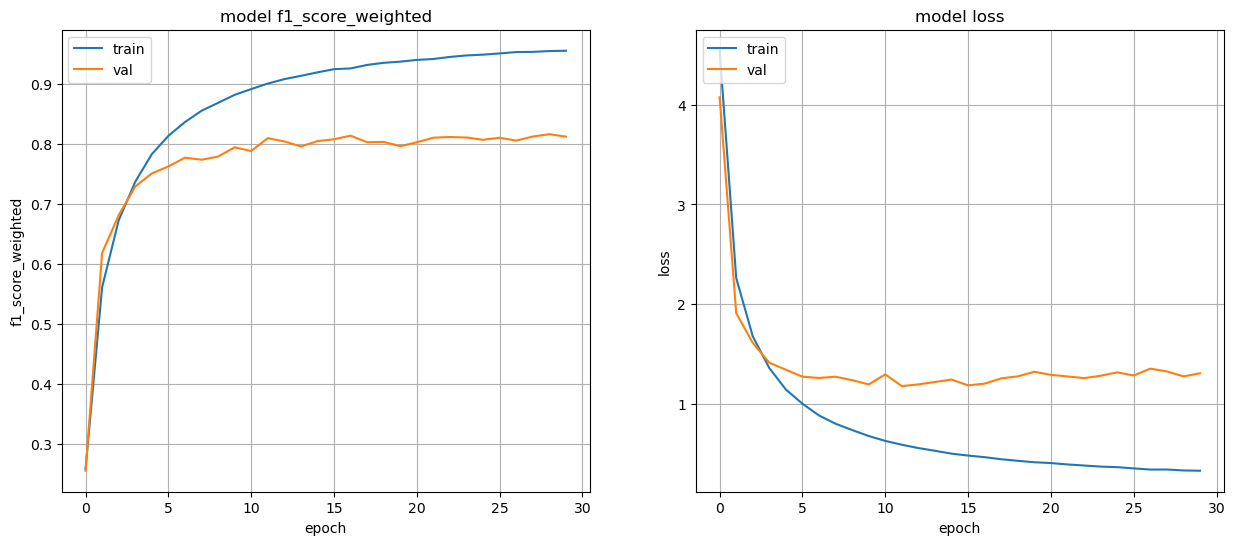

In [32]:
# Выводим графики обучения модели

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(history.history['f1_score'])
ax[0].plot(history.history['val_f1_score'])
ax[0].set_title('model f1_score_weighted')
ax[0].set_ylabel('f1_score_weighted')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')
ax[0].grid();

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
ax[1].grid();

In [34]:
# Выводим результат предсказания модели для валидационной выборки

score = model.evaluate(Xval, yval, batch_size=128, verbose=0)
print('\nЗначение метрики f1_score_weighted на валидационной выборке:', round(score[1], 4))


Значение метрики f1_score_weighted на валидационной выборке: 0.8119


In [35]:
# Получаем предсказанные моделью вероятности, затем получаем из нее предсказание класса и применяем обратное преобразование
# к ним с помощью LabelEncoder.

y_proba = model.predict(Xval, verbose = 0)
y_pred = np.empty((0, 1))
for i in range(0, len(y_proba)):
    y_pred = np.append(y_pred, np.argmax(y_proba[i]))
y_pred = y_pred.astype(int)
y_pred = encoder.inverse_transform(y_pred)

# Аналогично выполняем преобразование для валидационной выборки
y_val = np.empty((0, 1))
for i in range(0, len(yval)):
    y_val = np.append(y_val, np.argmax(yval[i]))
y_val = y_val.astype(int)
y_val = encoder.inverse_transform(y_val)

In [54]:
# Предсказание для тестовой выборки

df_test = pq.read_table('test.parquet').to_pandas()

# Предварительно создаем датафрейм для результатов
result = df_test[['product_id']]

# Аналогично тренировочной выборке выполняем предобработку на тестовой
text_fields = [json.loads(elem) for elem in df_test.text_fields.tolist()]
idx = df_test.index.tolist()

df = pd.DataFrame(text_fields, index=idx)
df.description = df.apply(lambda x: str(x.description) + ' ' + str(x.attributes), axis=1)
df['characteristics'] = df.apply(lambda x: str(x.custom_characteristics) + str(x.defined_characteristics) + str(x.filters), axis=1)
df.drop(columns=['custom_characteristics', 'defined_characteristics', 'filters', 'attributes'], inplace=True)

df_test = pd.concat([df_test, df], axis=1)
df_test.drop(columns=['text_fields'], inplace=True)

df_test['title'] = clean_text(df_test.title.tolist(), 'ru_simb')
df_test['description'] = clean_text(df_test.description.tolist(), 'ru_simb')
df_test['characteristics'] = clean_text(df_test.characteristics.tolist(), 'without_punctuation')

df_test.characteristics = df_test.characteristics.apply(lambda x: ' '.join([i for n, i in enumerate(x.split())
                                                                            if i not in x.split()[:n]]))
df_test.characteristics = df_test.apply(lambda x: str(x.shop_id) + ' ' + x.characteristics, axis=1)
df_test.drop(columns=['shop_id', 'shop_title', 'rating', 'sale'], inplace=True)
df_test['title_tokenized'] = tokenizer.texts_to_sequences(df_test.title)
df_test['description_tokenized'] = tokenizer.texts_to_sequences(df_test.description)
df_test['characteristics_tokenized'] = tokenizer.texts_to_sequences(df_test.characteristics)
df_test.drop(columns=['title', 'description', 'characteristics'])

Xtest = np.empty(shape=[len(df_test), 0], dtype='int32')
col_names = ['title', 'description', 'characteristics']
for i in range(3):
    Xtest_temp = pad_sequences(df_test[col_names[i]+'_tokenized'], maxlen=len_list[i], padding='post')
    Xtest = np.append(Xtest, Xtest_temp, axis=1)
print('Размер предобработанного тестового массива - ', Xtest.shape)

Размер предобработанного тестового массива -  (16860, 186)


In [55]:
# Получаем предсказанные моделью вероятности для тестовой выборки, получаем предсказание класса и применяем обратное 
# преобразование к ним с помощью LabelEncoder.

y_proba = model.predict(Xtest, verbose = 0)
y_pred = np.empty((0, 1))
for i in range(0, len(y_proba)):
    y_pred = np.append(y_pred, np.argmax(y_proba[i]))
y_pred = y_pred.astype(int)
y_pred = encoder.inverse_transform(y_pred)
result['predicted_category_id'] = y_pred

In [57]:
result.head(5)

,product_id,predicted_category_id
1,1997646,13389
2,927375,14922
3,1921513,2803
4,1668662,12524
5,1467778,13770


In [58]:
result = pa.Table.from_pandas(result)
pq.write_table(result, 'result.parquet')